In [ ]:
#importing all necessary libraries
import os
import cv2
import random
import shutil
import numpy as np
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import files
from IPython.display import display, Image


#Mounting the drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Cleaning the blurry,small,dark images

In [ ]:

#  Dataset base directory (UPDATE if needed)
base_dir = '/content/drive/MyDrive/vehicle_dataset/vehicle_dataset/train'

# Check if image is blurry using variance of Laplacian
def is_blurry(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance < threshold

# Check if image is too dark based on mean pixel intensity
def is_dark(image, threshold=40):
    return np.mean(image) < threshold

# Clean images in-place for a given class
def clean_images_in_place(class_path):
    kept, removed = 0, 0

    for img_name in os.listdir(class_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(class_path, img_name)

        try:
            img = cv2.imread(img_path)
            if img is None or img.shape[0] < 50 or img.shape[1] < 50:
                os.remove(img_path)
                removed += 1
                continue

            if is_blurry(img) or is_dark(img):
                os.remove(img_path)
                removed += 1
                continue

            kept += 1

        except Exception as e:
            print(f" Error with {img_path}: {e}")
            removed += 1
            if os.path.exists(img_path):
                os.remove(img_path)

    return kept, removed

#  Run Cleaning for ALL classes
summary = []

for class_folder in sorted(Path(base_dir).iterdir()):
    if not class_folder.is_dir():
        continue
    print(f" Cleaning class: {class_folder.name}")
    kept, removed = clean_images_in_place(str(class_folder))
    summary.append((class_folder.name, kept, removed))

#  Show summary
print("\n Dataset Cleaning Summary:")
for cls, kept, removed in summary:
    print(f" {cls}:  Kept = {kept} |  Removed = {removed}")


 Cleaning class: auto-rickshaw
 Cleaning class: bicycle
 Cleaning class: bus
 Cleaning class: car
 Cleaning class: e-rickshaw
 Cleaning class: mini-bus
 Cleaning class: mini-truck
 Cleaning class: motorcycle
 Cleaning class: rickshaw
 Cleaning class: tractor
 Cleaning class: truck
 Cleaning class: van

 Dataset Cleaning Summary:
 auto-rickshaw:  Kept = 377 |  Removed = 71
 bicycle:  Kept = 173 |  Removed = 90
 bus:  Kept = 210 |  Removed = 3
 car:  Kept = 105 |  Removed = 12
 e-rickshaw:  Kept = 95 |  Removed = 2
 mini-bus:  Kept = 12 |  Removed = 0
 mini-truck:  Kept = 373 |  Removed = 14
 motorcycle:  Kept = 200 |  Removed = 45
 rickshaw:  Kept = 21 |  Removed = 3
 tractor:  Kept = 80 |  Removed = 1
 truck:  Kept = 460 |  Removed = 21
 van:  Kept = 349 |  Removed = 2


#VEHICLE DATASET AUGMENTATION FOR CLASS BALANCING




In [ ]:
from tqdm import tqdm

# Set dataset path and target image count
DATASET_DIR = '/content/drive/MyDrive/vehicle_dataset/vehicle_dataset/train'
TARGET_IMAGES = 450  # Desired number of images per class


#Albumentations Augmentation Pipeline
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomShadow(p=0.3),
    A.ColorJitter(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.3),
    A.Resize(224, 224)  # Resize to match model input
])

#  Augmentation Function
def augment_and_save(image_path, save_dir, base_name, index):
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Skipping unreadable image: {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented = augmentor(image=image)
    aug_img = augmented['image']
    aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
    save_path = save_dir / f"{base_name}_aug{index}.jpg"
    cv2.imwrite(str(save_path), aug_img_bgr)


# Loop Through Classes and Augment If Needed

for class_folder in tqdm(sorted(Path(DATASET_DIR).iterdir()), desc="Processing Classes"):
    if not class_folder.is_dir():
        continue

    images = list(class_folder.glob("*.jpg"))
    num_images = len(images)

    if num_images == 0:
        print(f" [{class_folder.name}] Skipped (no images found)")
        continue

    if num_images >= TARGET_IMAGES:
        continue  # Already has enough images

    needed = TARGET_IMAGES - num_images
    print(f" [{class_folder.name}] Augmenting {needed} images...")

    for i in range(needed):
        base_img = random.choice(images)
        base_name = base_img.stem
        augment_and_save(base_img, class_folder, base_name, i + 1)

print("Augmentation complete. All classes balanced to", TARGET_IMAGES, "images.")

Processing Classes:   0%|          | 0/12 [00:00<?, ?it/s]

 [auto-rickshaw] Augmenting 160 images...


Processing Classes:   8%|▊         | 1/12 [00:04<00:49,  4.51s/it]

 [bicycle] Augmenting 439 images...


Processing Classes:  17%|█▋        | 2/12 [00:16<01:27,  8.73s/it]

 [bus] Augmenting 372 images...


Processing Classes:  25%|██▌       | 3/12 [00:26<01:26,  9.65s/it]

 [car] Augmenting 409 images...


Processing Classes:  33%|███▎      | 4/12 [00:38<01:21, 10.25s/it]

 [e-rickshaw] Augmenting 383 images...


Processing Classes:  42%|████▏     | 5/12 [00:50<01:16, 10.94s/it]

 [mini-bus] Augmenting 439 images...


Processing Classes:  50%|█████     | 6/12 [01:01<01:05, 10.88s/it]

 [mini-truck] Augmenting 82 images...


Processing Classes:  58%|█████▊    | 7/12 [01:04<00:42,  8.44s/it]

 [motorcycle] Skipped (no images found)
 [rickshaw] Skipped (no images found)
 [tractor] Augmenting 370 images...


Processing Classes:  83%|████████▎ | 10/12 [01:14<00:10,  5.43s/it]

 [truck] Augmenting 281 images...


Processing Classes:  92%|█████████▏| 11/12 [01:21<00:05,  5.92s/it]

 [van] Augmenting 188 images...


Processing Classes: 100%|██████████| 12/12 [01:26<00:00,  7.19s/it]

Augmentation complete. All classes balanced to 450 images.


#Dataset Directories and Device Configuration

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Vehicle_detection/vehicle_dataset"  # Root path of the dataset in Google Drive
TRAIN_DIR = f"{BASE_DIR}/train"  # Path to the training images
VAL_DIR = f"{BASE_DIR}/val"      # Path to the validation images

TARGET_IMAGES_PER_CLASS = 450  # Target number of images for each class after augmentation

# Automatically choose GPU if available, else fallback to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Data Augmentation & Preprocessing Pipeline


 This transformation pipeline is built using Albumentations.
 It resizes images and applies a series of augmentations to improve model generalization.
 These augmentations simulate variations like flipping, brightness/contrast changes,
 rotation, blurring, and color jitter. It also normalizes the image using ImageNet stats,
 which is standard when using pre-trained models.

In [ ]:
transform = A.Compose([
    A.Resize(height=224, width=224),  # Resize all images to 224x224 (standard for most CNNs)
    A.HorizontalFlip(p=0.5),          # Flip images horizontally with 50% probability
    A.RandomBrightnessContrast(p=0.2),# Randomly change brightness & contrast
    A.Rotate(limit=15),               # Random rotation within ±15 degrees
    A.GaussianBlur(p=0.1),            # Apply slight blur to simulate soft focus
    A.ColorJitter(p=0.2),             # Randomly change brightness, contrast, saturation, and hue
    A.Normalize(mean=(0.485, 0.456, 0.406),  # Normalize using ImageNet mean
                std=(0.229, 0.224, 0.225))  # Normalize using ImageNet std
])

#Training Configuration, Data Loaders, and Model Setup

In [12]:
# Training Hyperparameters
IMAGE_SIZE = 224         # Standard input image size for CNNs
BATCH_SIZE = 32          # Number of images per batch during training
EPOCHS = 10             # Total number of training epochs
MODEL_PATH = "vehicals_classifier.onnx"  # Path to save the ONNX exported model

#  Define transformation pipelines using torchvision
# These are applied before feeding images into the model
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),         # Resize to fixed size
    transforms.RandomHorizontalFlip(),                   # Data augmentation: flip
    transforms.ToTensor(),                               # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],           # Normalize using ImageNet stats
                         [0.229, 0.224, 0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),         # Resize for validation (no augmentations)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load training and validation datasets from directory structure
train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_data = datasets.ImageFolder(VAL_DIR, transform=val_tf)

# Wrap datasets in DataLoader to enable mini-batch training
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

# Save class labels to file for later use during prediction
with open("/content/drive/MyDrive/Vehicle_detection/vehicle_dataset/sample_classe.txt", 'w') as f:
    for c in train_data.classes:
        f.write(f"{c}\n")

#  Initialize EfficientNet-B0 model with pretrained weights
# and modify the output layer to match the number of vehicle classes
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=len(train_data.classes))
model.to(DEVICE)

#  Define loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Standard loss for classification
optimizer = optim.AdamW(model.parameters(), lr=1e-4)       # AdamW optimizer (better regularization)

#  Initialize variables to store training/validation accuracy history
best_acc = 0
train_acc, val_acc = [], []


#Train the Dataset

In [14]:
!pip install onnx
#  Loop through each training epoch
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    correct, total = 0, 0  # Initialize training accuracy counters
    #  Iterate over training batches
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)  # Move data to GPU/CPU
        optimizer.zero_grad()              # Reset gradients
        out = model(x)                     # Forward pass
        loss = criterion(out, y)           # Compute loss
        loss.backward()                    # Backpropagation
        optimizer.step()                   # Update model weights

        #  Update training accuracy
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    # Record training accuracy for this epoch
    acc = correct / total
    train_acc.append(acc)

    #  Evaluate on validation data
    model.eval()  # Set model to evaluation mode
    val_correct, val_total = 0, 0
    preds, labels = [], []

    with torch.no_grad():  # Disable gradient computation for validation
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            pred = out.argmax(1)

            # Save predictions and labels for metrics
            preds.extend(pred.cpu().numpy())
            labels.extend(y.cpu().numpy())

            #  Update validation accuracy
            val_correct += (pred == y).sum().item()
            val_total += y.size(0)

    #  Record validation accuracy
    v_acc = val_correct / val_total
    val_acc.append(v_acc)

    #  Print training and validation results for this epoch
    print(f"Epoch {epoch+1}/{EPOCHS} Train Acc: {acc:.4f} | Val Acc: {v_acc:.4f}")

    #  Save best model by exporting to ONNX if validation accuracy improves
    if v_acc > best_acc:
        best_acc = v_acc
        torch.onnx.export(
            model,
            torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE),  # Dummy input
            MODEL_PATH,                                            # Export path
            input_names=['input'],
            output_names=['output']
        )


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 110.0 MB/s eta 0:00:00
Epoch 1/10 Train Acc: 0.9198 | Val Acc: 0.8144
Epoch 2/10 Train Acc: 0.9684 | Val Acc: 0.8275
Epoch 3/10 Train Acc: 0.9857 | Val Acc: 0.8405
Epoch 4/10 Train Acc: 0.9944 | Val Acc: 0.8431
Epoch 5/10 Train Acc: 0.9946 | Val Acc: 0.8366
Epoch 6/10 Train Acc: 0.9977 | Val Acc: 0.8510
Epoch 7/10 Train Acc: 0.9967 | Val Acc: 0.8562
Epoch 8/10 Train Acc: 0.9984 | Val Acc: 0.8667
Epoch 9/10 Train Acc: 0.9962 | Val Acc: 0.8771
Epoch 10/10 Train Acc: 0.9957 | Val Acc: 0.8601


#Model Performance Evaluation and Visualization


 Classification Report:
               precision    recall  f1-score   support

auto-rickshaw       0.83      0.88      0.85       137
      bicycle       0.96      0.96      0.96        69
          bus       0.78      0.76      0.77        71
          car       0.86      0.71      0.78        35
   e-rickshaw       0.83      0.83      0.83         6
     mini-bus       0.50      1.00      0.67         1
   mini-truck       0.82      0.91      0.86       102
   motorcycle       0.92      0.97      0.94        69
     rickshaw       1.00      0.75      0.86        12
      tractor       0.75      1.00      0.86         3
        truck       0.82      0.75      0.78       157
          van       0.95      0.94      0.95       103

     accuracy                           0.86       765
    macro avg       0.84      0.87      0.84       765
 weighted avg       0.86      0.86      0.86       765


 Final Validation Accuracy: 0.8601
 mAP (Macro-Averaged): 0.7364


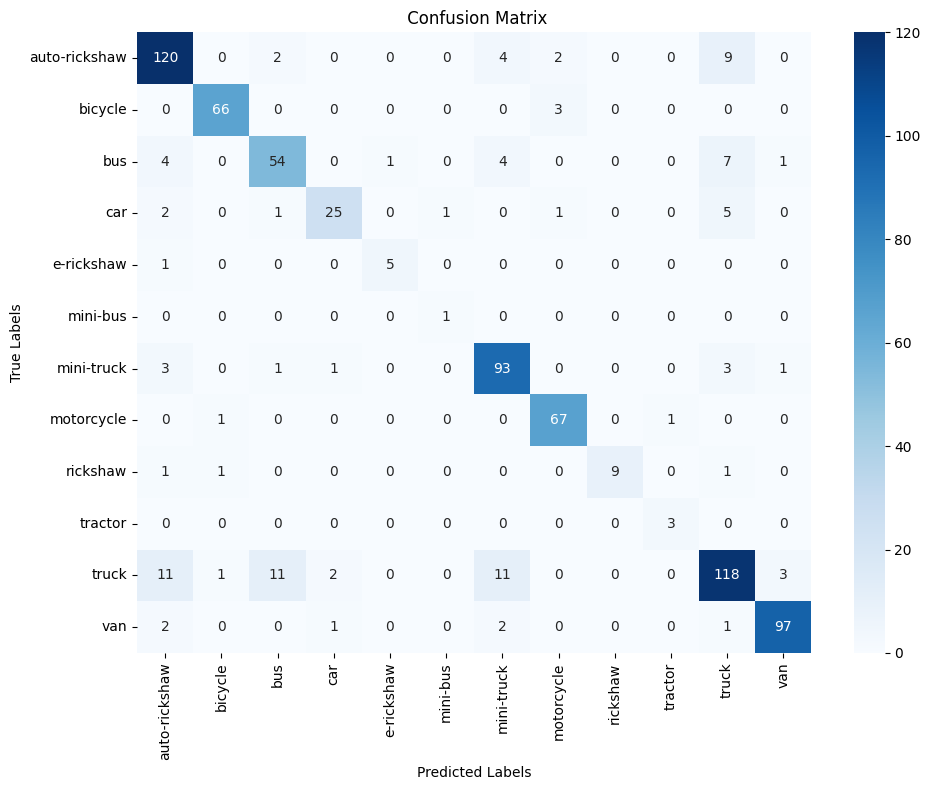

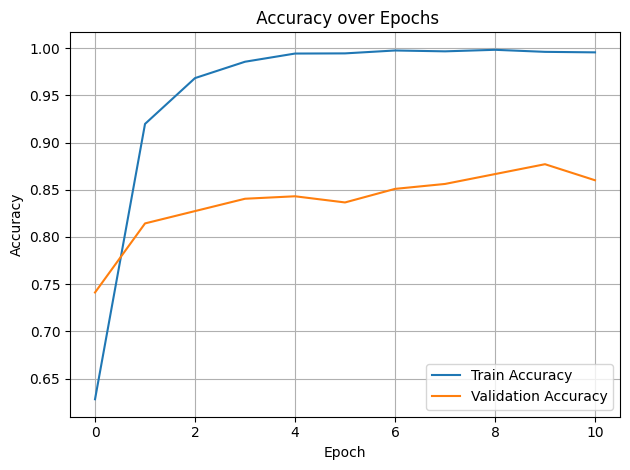

In [15]:
from sklearn.metrics import average_precision_score
import seaborn as sns
import torch.nn.functional as F

print("\n Classification Report:")
print(classification_report(labels, preds, target_names=train_data.classes))

#  Accuracy

final_val_acc = val_acc[-1]
print(f"\n Final Validation Accuracy: {final_val_acc:.4f}")


#  Mean Average Precision (mAP)
n_classes = len(train_data.classes)
labels_onehot = np.eye(n_classes)[labels]

# You must use softmax output for real mAP, here we approximate with one-hot
preds_onehot = np.eye(n_classes)[preds]  # Approximated if real probas not available

try:
    map_score = average_precision_score(labels_onehot, preds_onehot, average='macro')
    print(f" mAP (Macro-Averaged): {map_score:.4f}")
except Exception as e:
    print(" Failed to compute mAP:", e)

#  Confusion Matrix

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes,
            cmap='Blues')
plt.title(' Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

#  Learning Curves

plt.figure()
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title(" Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Predection of the vehicle


Saving van.png to van.png
Predicted Class: van (98.52% confidence)


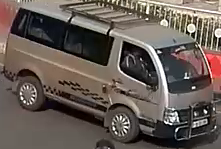

In [18]:
#!pip install onnxruntime
def predict_image(img_path):
    import onnxruntime as ort
    from PIL import Image as PILImage

    image = PILImage.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).numpy()
    session = ort.InferenceSession(MODEL_PATH)
    outputs = session.run(None, {"input": input_tensor})
    probs = torch.softmax(torch.tensor(outputs[0]), dim=1)
    idx = torch.argmax(probs).item()
    confidence = probs[0][idx].item()

    with open("/content/drive/MyDrive/Vehicle_detection/sample_classe.txt") as f:
        classes = [line.strip() for line in f]

    print(f"Predicted Class: {classes[idx]} ({confidence*100:.2f}% confidence)")
    display(PILImage.open(img_path))

# Upload and test
uploaded = files.upload()
for filename in uploaded:
    predict_image(filename)


#Exporting the PyTorch Model to ONNX Format

In [19]:
# Create a dummy input tensor with the same shape as a real image input
# Format: (batch_size, channels, height, width) — here, batch_size=1
dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)

# Export the trained PyTorch model to ONNX format
torch.onnx.export(model,                      #  The trained model to export
                  dummy_input,                #  Dummy input simulating an actual image tensor
                  "vehicles_classifier.onnx",  # Output ONNX file name
                  input_names=['input'],      #  Name of the model's input node
                  output_names=['output'],    #  Name of the model's output node
                  dynamic_axes={              #  Allow batch size to be dynamic (flexible during inference)
                      'input': {0: 'batch_size'},
                      'output': {0: 'batch_size'}
                  },
                  export_params=True,         #  Include trained weights in the exported file
                  opset_version=11)           #  ONNX operator set version (11 for wide compatibility)